<a href="https://colab.research.google.com/github/katarinagresova/XAI_MALTAomics23/blob/dev/interpreting_sequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting Neural Networks for Genomic Data

In this notebook we will look at some ways how we can interpret neural networks trained on genomic sequence data.

# 1. Setup

## 1.1. Dependencies

In [1]:
!pip install deeplift captum genomic-benchmarks -q

## 1.2. Imports

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from genomic_benchmarks.dataset_getters.pytorch_datasets import HumanNontataPromoters

import captum

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

/usr/local/lib/python3.10/dist-packages/genomic_benchmarks/utils/datasets.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# 2. Non-TATA promoters

## 2.1. Data

We will use the same dataset as in [MALTA_02_Notebook](https://colab.research.google.com/drive/17DIEF820ZBrMBeXz1tR2pRIhRoTXOmxT?usp=sharing). However, we don't need the whole dataset, just the positive samples.

In [3]:
test_dset = HumanNontataPromoters('test')
test_df = pd.DataFrame(data=[{'x':x,'y':y} for x,y in test_dset])

pos_df = test_df[test_df["y"] == 1].reset_index(drop=True)
pos_df.head()

,x,y
0,TCCCGCCGCCGGCGGAAGCCGAGTCAGCCCGAGGCCGAGCCGAGAC...,1
1,GTGTACGCTGTGAAGGTGTTTCTCTTCACAGTTCCCCGCCCTCTAG...,1
2,CAGCCCGCGCGGCGTCACGTGACCTCTAGTTCCGCACCGCCCCCCC...,1
3,ACCCAGCCTGTCAGTCCATTTTGGTTGCAGCCACCCCTCCCTGATG...,1
4,TGACTGCCCGATGGTGACACTGAGGTTTCATAGAGCACTGTTGTAT...,1


To process the data, we need a `CNNDataset` class introduced in the MALTA_02_Notebook.



In [4]:
class CNNDataset(Dataset):
    def __init__(self, df):
      self.df = df
      self.vocab = {'N':0,'A':1,'C':2,'T':3,'G':4}

    def __len__(self):
      return len(self.df)

    def __getitem__(self, idx):
      sequence, label = self.df.iloc[idx]

      numericalized = [self.vocab[c] for c in sequence]
      numericalized_tensor = torch.tensor(numericalized)
      ohe_seq = torch.nn.functional.one_hot(
          numericalized_tensor,
          num_classes=len(self.vocab.keys())
      )

      x = ohe_seq.permute(1,0).float()

      y = torch.tensor([label]).float()

      return x, y

pos_dset = CNNDataset(pos_df)
pos_loader = DataLoader(pos_dset, batch_size=1, shuffle=True)

In [5]:
sample, label = next(iter(pos_loader))
print(sample)
print(label)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 1., 0.]]])
tensor([[1.]])


## 2.2. Model

In [6]:
class CNN(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv1d(in_channels=in_channels, out_channels=16, kernel_size=3),
        nn.MaxPool1d(kernel_size=3),
        nn.ReLU(),
        nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3),
        nn.MaxPool1d(kernel_size=3),
        nn.ReLU(),
        nn.Flatten(),
        nn.LazyLinear(out_features=1),
        nn.Sigmoid(),
    )

  def forward(self,x):
    return self.net(x)

In [7]:
!wget https://github.com/katarinagresova/XAI_MALTAomics23/raw/dev/cnn_model.pth

--2023-09-12 20:54:54--  https://github.com/katarinagresova/XAI_MALTAomics23/raw/dev/cnn_model.pth
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/katarinagresova/XAI_MALTAomics23/dev/cnn_model.pth [following]
--2023-09-12 20:54:54--  https://raw.githubusercontent.com/katarinagresova/XAI_MALTAomics23/dev/cnn_model.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13159 (13K) [application/octet-stream]
Saving to: ‘cnn_model.pth.1’

cnn_model.pth.1     100%[===================>]  12.85K  --.-KB/s    in 0s      

2023-09-12 20:54:54 (96.4 MB/s) - ‘cnn_model.pth.1’ saved [13159/13159]



In [8]:
model = CNN(in_channels=5)
model.load_state_dict(torch.load("cnn_model.pth"))
model.eval()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


CNN(
  (net): Sequential(
    (0): Conv1d(5, 16, kernel_size=(3,), stride=(1,))
    (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
    (4): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=1, bias=True)
    (8): Sigmoid()
  )
)

In [9]:
model(sample)

tensor([[0.9851]], grad_fn=<SigmoidBackward0>)

## 2.3. Kernel visualization

In [10]:
layer = 0
kernels = model.net[layer].weight.data.clone()

In [11]:
len(kernels)

16

In [12]:
kernels[0]

tensor([[ 0.2252,  0.2233,  0.0986],
        [ 0.0618, -0.2263,  0.2711],
        [ 0.2672, -0.2736,  0.2790],
        [-0.6478,  0.5111, -0.6451],
        [ 0.0900, -0.3000,  0.1418]])

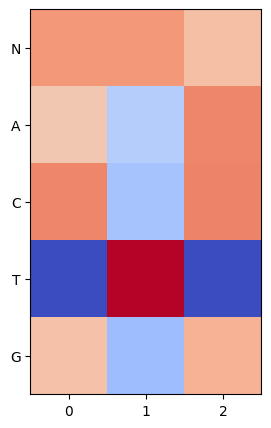

In [13]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.imshow(kernels[0], cmap="coolwarm")
ax.set_yticks(range(5))
ax.set_yticklabels(["N", "A", "C", "T", "G"]);

In [14]:
from deeplift.visualization import viz_sequence

def viz_kernels(kernels):
  # constants for the visualization
  height_padding_factor = 0.2
  length_padding = 1.0
  subticks_frequency = 1.0
  # this is usualy not needed to define,
  # but we have nucleotides in order ACTG
  # and DeepLIFT is expecting them as ACGT by default
  custom_plot_funcs = {
      0:viz_sequence.plot_a,
      1:viz_sequence.plot_c,
      2:viz_sequence.plot_t,
      3:viz_sequence.plot_g
  }
  custom_colors = {0:'green', 1:'blue', 2:'red', 3:'orange'}

  # prepare the plot for  kernels
  fig, axs = plt.subplots(1, len(kernels), figsize=(20, 5), sharex=True, sharey=True)

  # get maximum height of stacked letters
  max_pos = 0
  min_neg = 0
  for kernel in kernels:
    for row in kernel:
      max_pos = max(max_pos, sum(row[row > 0]))
      min_neg = min(min_neg, sum(row[row < 0]))

  for id in range(len(kernels)):

    kernel = kernels[id]

    # uncomment the line below to plot only positive values
    #kernel[kernel < 0] = 0

    # call the DeepLIFT visualization function
    viz_sequence.plot_weights_given_ax(
          ax=axs[id],
          array=kernel,
          height_padding_factor=height_padding_factor,
          length_padding=length_padding,
          subticks_frequency=subticks_frequency,
          highlight={},
          plot_funcs=custom_plot_funcs,
          colors=custom_colors,
    )

    # add the vertical line to separate positive and negative values
    axs[id].axhline(y=0.0, color='r', linestyle='-')
    # set height of the figures
    axs[id].set_ylim(min_neg, max_pos)

  fig.tight_layout()

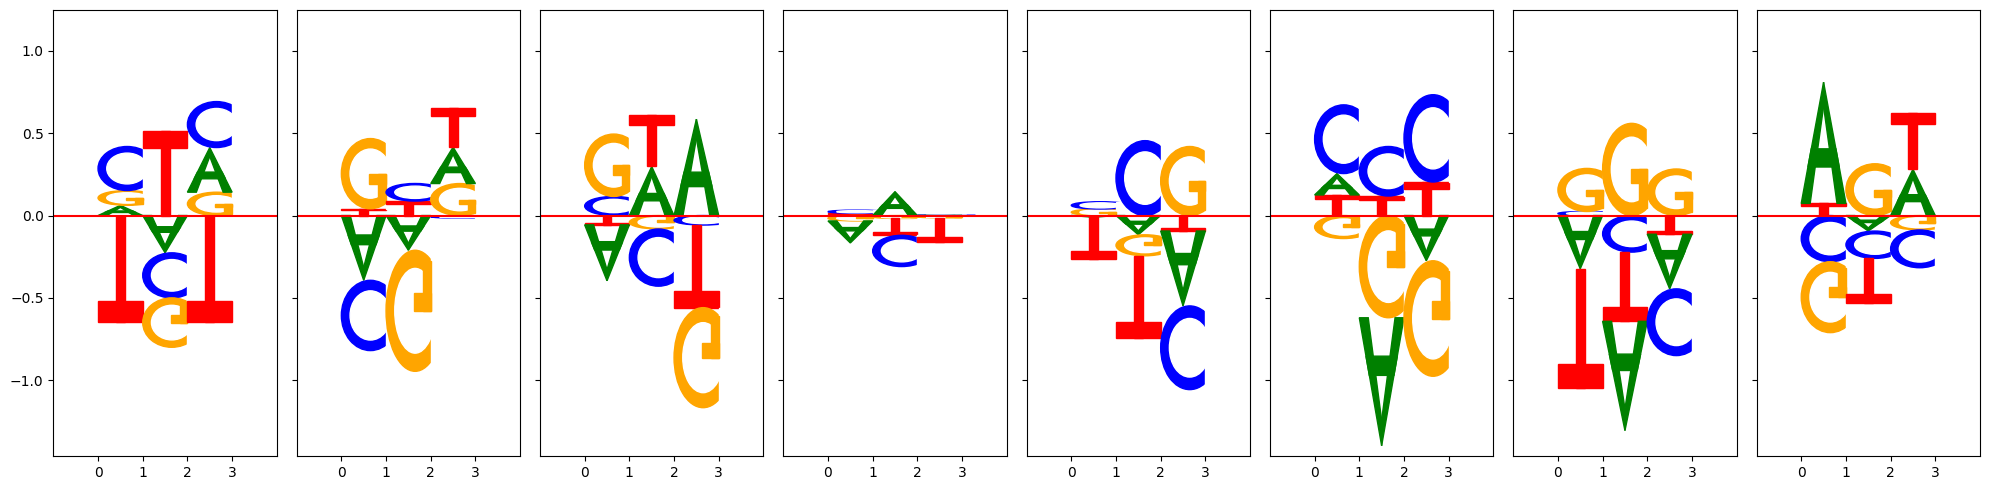

In [15]:
# remove values for the N nucleotide (DeepLIFT is unable to work with it)
kernels = kernels[:, 1:, :].numpy().copy()

viz_kernels(kernels[:8])

## 2.4. Sample visualization

In [16]:
sample, label = next(iter(pos_loader))
print(sample)
print(label)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.]]])
tensor([[1.]])


In [17]:
model(sample)

tensor([[0.9990]], grad_fn=<SigmoidBackward0>)

In [18]:
from captum.attr import IntegratedGradients, Occlusion, GradientShap, DeepLift, GuidedBackprop

In [19]:
explainer = Occlusion(model)
attribution = explainer.attribute(sample, sliding_window_shapes=(4,4))

In [20]:
attribution.shape

torch.Size([1, 5, 251])

In [21]:
def plot_attribution(attribution, sample):

  custom_plot_funcs = {
      0:viz_sequence.plot_a,
      1:viz_sequence.plot_c,
      2:viz_sequence.plot_t,
      3:viz_sequence.plot_g
  }
  custom_colors = {0:'green', 1:'blue', 2:'red', 3:'orange'}

  if attribution.shape[1] == 5:
      attribution = attribution[:, 1:, :]
      sample = sample[0, 1:, :]

  attr = np.sum(attribution.detach().numpy(), axis=0) * sample.numpy()
  viz_sequence.plot_weights(attr, subticks_frequency=20, plot_funcs=custom_plot_funcs,
        colors=custom_colors)

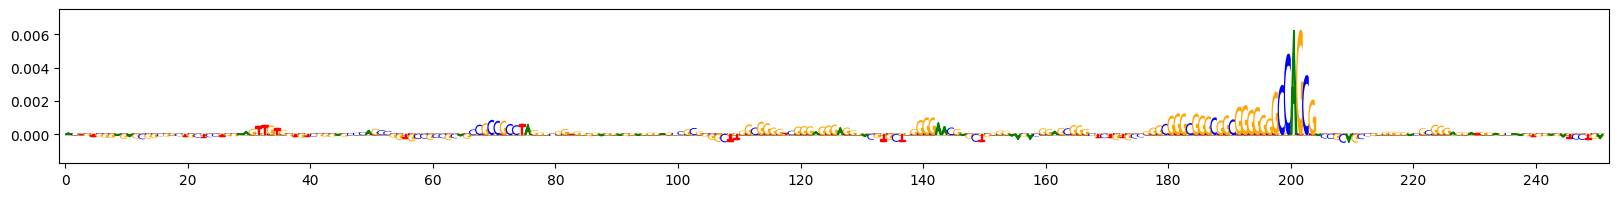

In [22]:
plot_attribution(attribution, sample)

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


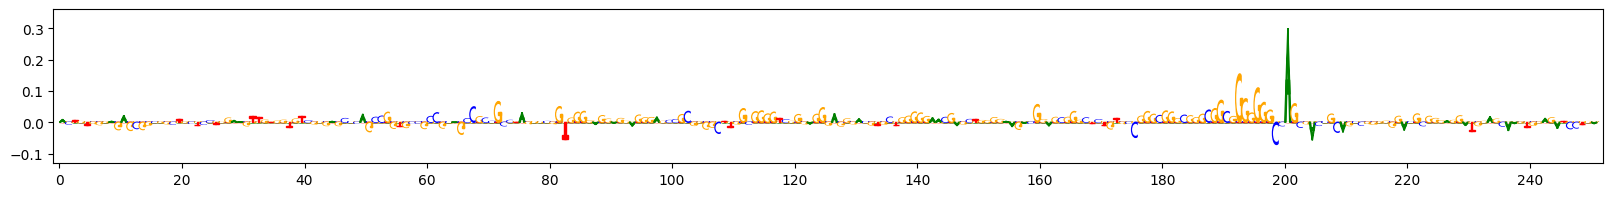

In [23]:
explainer = DeepLift(model)
attribution = explainer.attribute(sample)
plot_attribution(attribution, sample)

### Exercise 1: Try other methods

We are using Captum to interpret the PyTorch model. Look at the [documentation of Attribution methods](https://captum.ai/api/attribution.html) and try to get results using other methods. `IntegratedGradients`, `GradientShap` or `GuidedBackprop` could be a good option.

`IntegratedGradients` and `GuidedBackprop` can be run in 3 lines of code:

```
explainer = SomeExplainer(model)
attribution = explainer.attribute(sample)
plot_attribution(attribution, sample)
```

`GradientShap` requires to define a baseline. You can use random baseline as defined in the [documentation](https://captum.ai/api/gradient_shap.html) or you can try to use a zero baseline:

`baselines = torch.zeros(sample.shape)`

In [24]:
## IntegratedGradients

In [25]:
## GradientShap

In [26]:
## GuidedBackprop

### Exercise 2: Visuzalize other samples

Run the 2.4. section again to see results for different sample. Cell

```
sample, label = next(iter(pos_loader))
print(sample)
print(label)
```

will load a new sample that will be used in the following cells of a section.

# 3. Artificial motif

## 3.1. Synthetic dataset

In [27]:
def random_dna(length=100):
  return ''.join(random.choices(["A", "C", "T", "G"], k=length))

In [28]:
random_dna(length=10)

'CCGGATCAGA'

In [29]:
def random_dna_with_acc_motif(length=100):
    acc_motifs = [
      "ACCCATGG",
      "ACCGATGG",
      "ACCCATGC",
      "ACCGATGC"
    ]

    motif_id = random.randrange(len(acc_motifs))
    start_pos = random.randrange(SEQ_LEN - len(acc_motifs[motif_id]))
    dna = random_dna(start_pos) + acc_motifs[motif_id] + random_dna(SEQ_LEN - start_pos - len(acc_motifs[motif_id]))

    return dna

In [30]:
SEQ_LEN = 100
SEQ_COUNT = 10000

neg_seqs = [random_dna(length=SEQ_LEN) for _ in range(SEQ_COUNT)]
pos_seqs = [random_dna_with_acc_motif(length=SEQ_LEN) for _ in range(SEQ_COUNT)]

motif_df = pd.DataFrame(np.array([neg_seqs + pos_seqs, [0] * len(neg_seqs) + [1] * len(neg_seqs)]).T, columns=["x", "y"])

motif_df.head()

,x,y
0,GTTCTACAGCCACACGTGTATTGCCGCGTGCGGAGGCAGAGCGTGG...,0
1,CGGAGGGGTTACCCCCTTGAACTGTATTAAATAAGAACATTTACAT...,0
2,CTCAAGTTCTATTTCAGCACGAATGATCCCAACCGACGTAATTCTC...,0
3,AATGCGTGACGGCAAGAGTACTGTCTTTAGTGCCTCGACGGAGCAA...,0
4,CAGTGGTACGTACGCGCAGGCCTTAGGCTAATTCGGTTCCGTCTTA...,0


In [31]:
## only difference from CNNDataset is that we do not code N character -> we code only 4 characters
class CNNDataset4(Dataset):
    def __init__(self, df):
      self.df = df
      self.vocab = {'A':0,'C':1,'T':2,'G':3}

    def __len__(self):
      return len(self.df)

    def __getitem__(self, idx):
      sequence, label = self.df.iloc[idx]

      numericalized = [self.vocab[c] for c in sequence]
      numericalized_tensor = torch.tensor(numericalized)
      ohe_seq = torch.nn.functional.one_hot(
          numericalized_tensor,
          num_classes=len(self.vocab.keys())
      )

      # x = ohe_seq.flatten().float()
      x = ohe_seq.permute(1,0).float()

      y = torch.tensor([float(label)])

      return x, y

train_dset = CNNDataset4(motif_df)
train_loader = DataLoader(train_dset, batch_size=32, shuffle=True)

## 3.2. Model

In [32]:
class CNN(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv1d(in_channels=in_channels, out_channels=16, kernel_size=3),
        nn.MaxPool1d(kernel_size=3),
        nn.ReLU(),
        nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3),
        nn.MaxPool1d(kernel_size=3),
        nn.ReLU(),
        nn.Flatten(),
        nn.LazyLinear(out_features=1),
        nn.Sigmoid(),
    )

  def forward(self,x):
    return self.net(x)

In [33]:
cnn_model = CNN(in_channels=4)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [34]:
def train(model, dataset, batch_size=32, lr=1e-3, epochs=3):
  train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  loss_function = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  for epoch in range(epochs):
    batch_losses = []
    for batch_x, batch_y in train_loader:
      outputs = model(batch_x)
      loss = loss_function(outputs, batch_y)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      batch_losses.append(loss.item())

    print('Mean loss', np.mean(batch_losses))

In [35]:
train(cnn_model, train_dset, epochs=5)

Mean loss 0.6615255416870117
Mean loss 0.2750344720542431
Mean loss 0.08754884111583233
Mean loss 0.05825960486680269
Mean loss 0.04814411241188645


## 3.3. Testing dataset

In [36]:
SEQ_LEN = 100
SEQ_COUNT = 10

neg_seqs = [random_dna(length=SEQ_LEN) for _ in range(SEQ_COUNT)]
pos_seqs = [random_dna_with_acc_motif(length=SEQ_LEN) for _ in range(SEQ_COUNT)]

pos_df = pd.DataFrame(np.array([pos_seqs, [1] * len(pos_seqs)]).T, columns=["x", "y"])
neg_df = pd.DataFrame(np.array([neg_seqs, [0] * len(neg_seqs)]).T, columns=["x", "y"])

pos_df.head()

,x,y
0,GGCGAGGGAGCTGAGTACATACCGATGGGTGATTGACCGAATTTAG...,1
1,CGACCACGGAACTCACTGAACGGTCTTAAGGCGACTCCCCCGATTG...,1
2,ATAGCACAGAGTGCGGTTACAATGTTTCTTTACCCATGGGGGAATG...,1
3,CAGAGGTAGAGACTGGAGCCGCGTGGAAGCATGACCCTTGCCGCCC...,1
4,AGATGGACGGCAGGTACCGATGGTCTGTCGACCCTATAGTTTGTTG...,1


In [37]:
pos_dset = CNNDataset4(pos_df)
pos_loader = DataLoader(pos_dset, batch_size=1, shuffle=False)

neg_dset = CNNDataset4(neg_df)
neg_loader = DataLoader(neg_dset, batch_size=1, shuffle=False)

In [38]:
sample, label = next(iter(pos_loader))

[Text(0, 0, 'A'), Text(0, 1, 'C'), Text(0, 2, 'T'), Text(0, 3, 'G')]

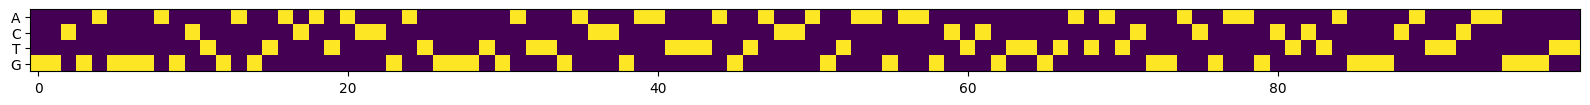

In [39]:
fig, ax = plt.subplots(1,1, figsize=(20, 2))
ax.imshow(sample.numpy()[0, :, :])
ax.set_yticks(range(4))
ax.set_yticklabels(["A", "C", "T", "G"])

## 3.4. Kernel visualization

In [40]:
layer = 0
kernels = cnn_model.net[layer].weight.data.clone()

In [41]:
kernels[0]

tensor([[-0.2493, -1.0239, -0.1180],
        [-0.4643,  0.3517, -0.2080],
        [-0.5883, -0.6206,  0.4185],
        [ 0.4921,  0.4523, -0.0099]])

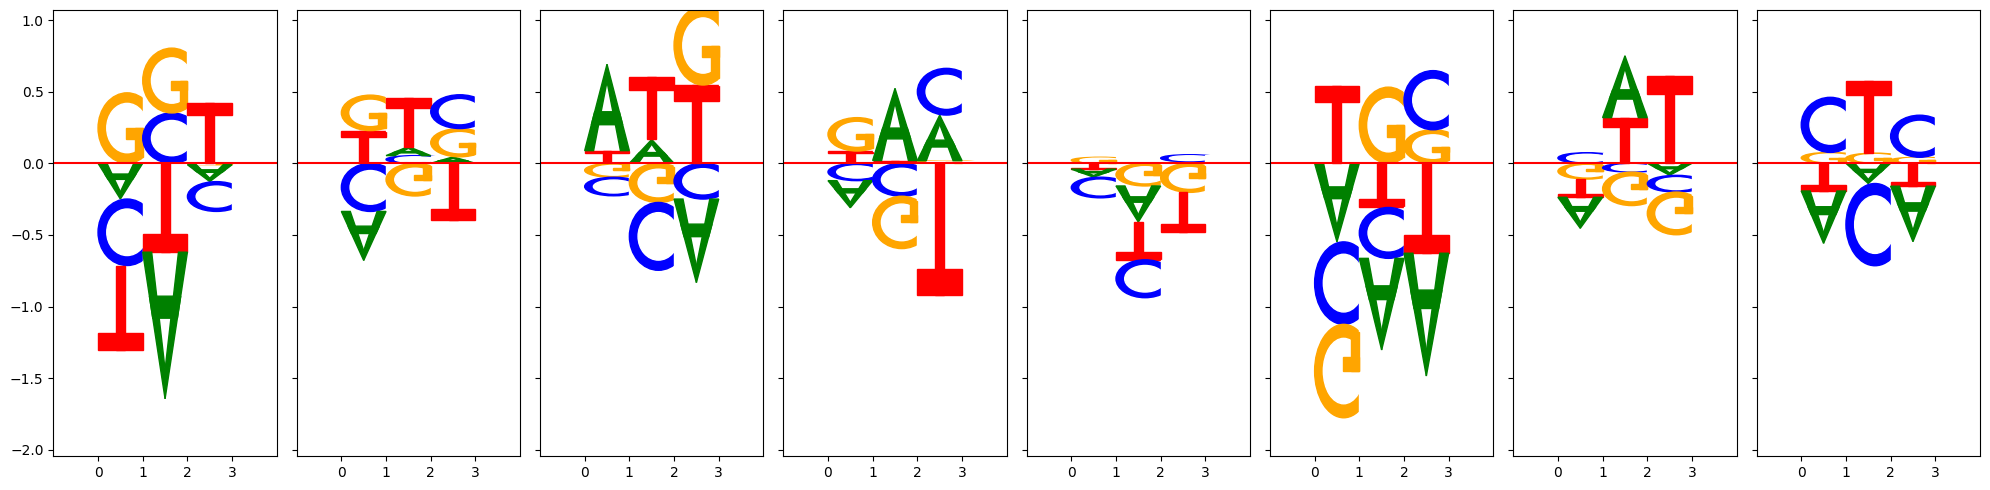

In [42]:
viz_kernels(kernels[:8].numpy())

For a reminder, these are the motifs we planted into the random DNA sequences:

```
acc_motifs = [
  "ACCCATGG",
  "ACCGATGG",
  "ACCCATGC",
  "ACCGATGC"
]
```

## 3.5. Sample visualization

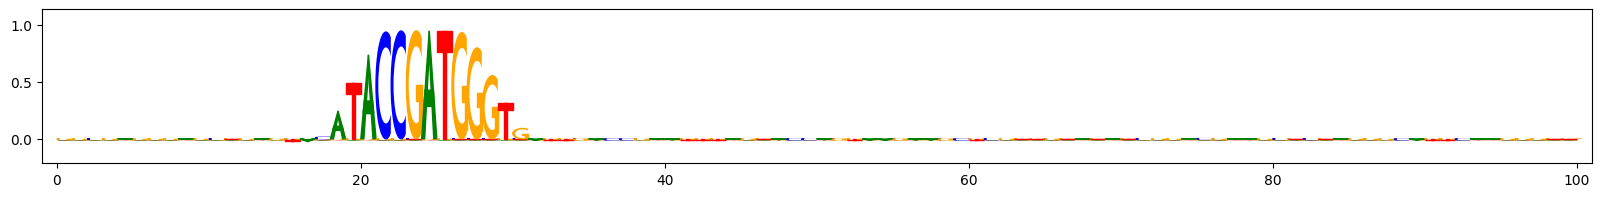

In [43]:
explainer = Occlusion(cnn_model)
attribution = explainer.attribute(sample, sliding_window_shapes=(4, 4))
plot_attribution(attribution, sample)

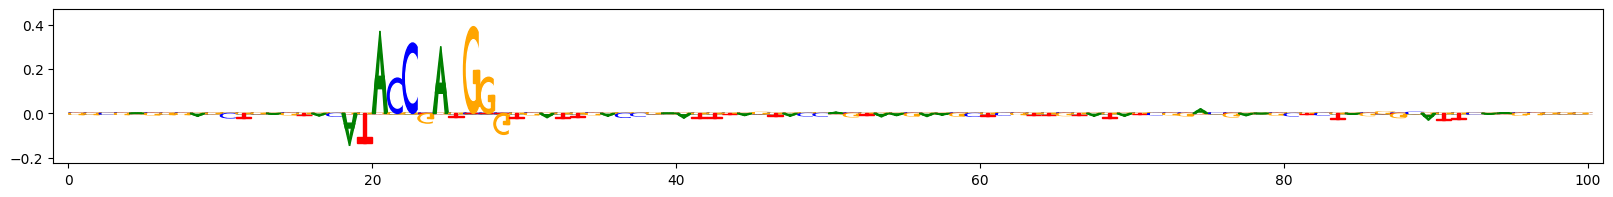

In [44]:
explainer = GradientShap(cnn_model)
baselines = torch.zeros((10, 4, 100))
attribution = explainer.attribute(sample, baselines)
plot_attribution(attribution, sample)

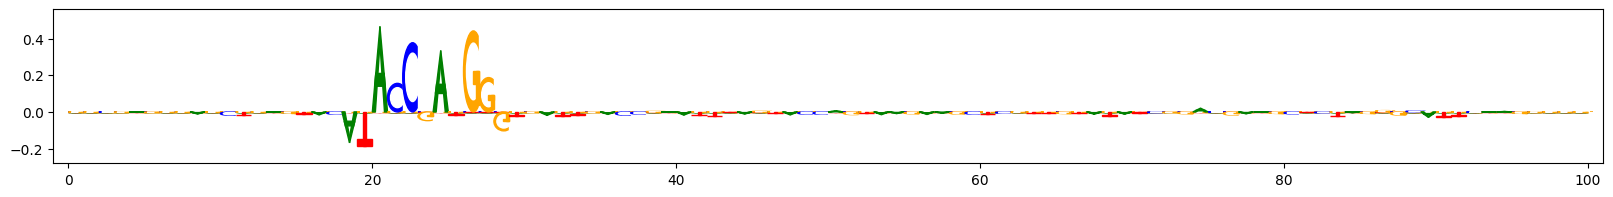

In [45]:
explainer = IntegratedGradients(cnn_model)
attribution = explainer.attribute(sample)
plot_attribution(attribution, sample)

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


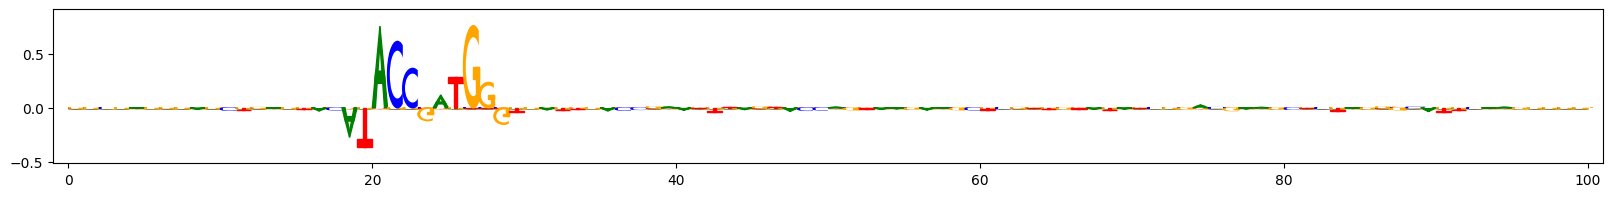

In [46]:
explainer = DeepLift(cnn_model)
attribution = explainer.attribute(sample)
plot_attribution(attribution, sample)

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


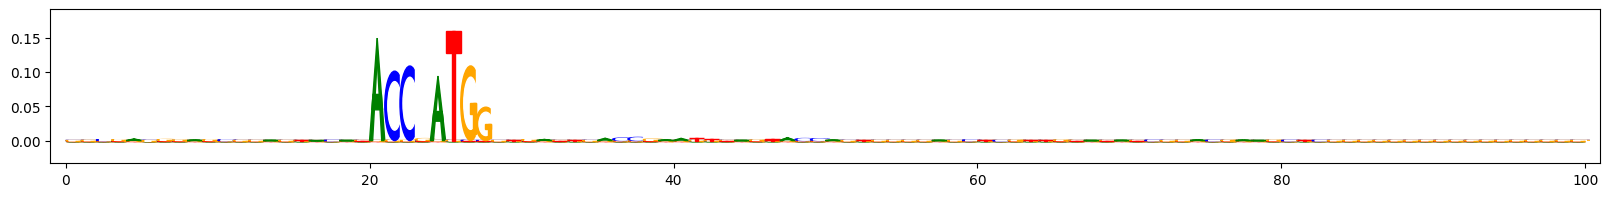

In [47]:
explainer = GuidedBackprop(cnn_model)
attribution = explainer.attribute(sample)
plot_attribution(attribution, sample)